# ColQwen2: Generate your own similarity maps 👀

[![Colab](https://img.shields.io/badge/Open_in_Colab-F9AB00?logo=googlecolab&logoColor=fff&style=for-the-badge)](https://colab.research.google.com/github/tonywu71/colpali-cookbooks/blob/main/examples/gen_colqwen2_similarity_maps.ipynb)
[![GitHub](https://img.shields.io/badge/ColPali_Cookbooks-100000?style=for-the-badge&logo=github&logoColor=white)](https://github.com/tonywu71/colpali-cookbooks)
[![arXiv](https://img.shields.io/badge/arXiv-2407.01449-b31b1b.svg?style=for-the-badge)](https://arxiv.org/abs/2407.01449)
[![Hugging Face](https://img.shields.io/badge/Vidore-FFD21E?style=for-the-badge&logo=huggingface&logoColor=000)](https://huggingface.co/vidore)
[![X](https://img.shields.io/badge/Thread-%23000000?style=for-the-badge&logo=X&logoColor=white)](https://x.com/tonywu_71/status/1809183824464560138)

## Introduction

With our new model *ColQwen2*, we propose to leverage VLMs to construct efficient multi-vector embeddings in the visual space for document retrieval. By feeding the ViT output patches from Qwen2-VL to a linear projection, we create a multi-vector representation of documents. We train the model to maximize the similarity between these document embeddings and the query embeddings, following the ColBERT method.

Using ColQwen2 removes the need for potentially complex and brittle layout recognition and OCR pipelines with a single model that can take into account both the textual and visual content (layout, charts, ...) of a document.

ColQwen2 is also highly interpretable: similarity maps can be obtained between patches and query tokens. These maps highlight ColQwen2’s strong OCR capabilities and chart understanding.

![Similarity map examples](https://github.com/tonywu71/colpali-cookbooks/blob/main/assets/interpretability/similarity_maps.jpeg?raw=true)

The following notebook guide you through how to generate your own similarity maps.

## Hardware Requirements

You can run it on Google Colab (using the free-tier T4 GPU) or locally (tested on a M2 Pro Mac).


## Imports

This notebook leverages [`colpali-engine`](https://github.com/illuin-tech/colpali), the official implementation of ColPali and ColQwen2. This package also contains the training code (processor, collator, trainer...) for fine-tuning these models on your own dataset.

Make sure you install the `colpali-engine[interpretability]` optional dependencies!

In [ ]:
!pip install -q -U "colpali-engine[interpretability]>=0.3.2,<0.4.0"

In [ ]:
import pprint
from io import BytesIO
from pathlib import Path
from typing import Optional, cast

import matplotlib.pyplot as plt
import requests
import torch
from colpali_engine.interpretability import (
    get_similarity_maps_from_embeddings,
    plot_all_similarity_maps,
    plot_similarity_map,
)
from colpali_engine.models import ColQwen2, ColQwen2Processor
from colpali_engine.utils.torch_utils import get_torch_device
from PIL import Image

## A few custom utils

In [ ]:
def load_image_from_url(url: str) -> Image.Image:
    """
    Load a PIL image from a valid URL.
    """
    response = requests.get(url)
    return Image.open(BytesIO(response.content))


def scale_image(image: Image.Image, new_height: int = 1024) -> Image.Image:
    """
    Scale an image to a new height while maintaining the aspect ratio.
    """
    # Calculate the scaling factor
    width, height = image.size
    aspect_ratio = width / height
    new_width = int(new_height * aspect_ratio)

    # Resize the image
    scaled_image = image.resize((new_width, new_height))

    return scaled_image

## Load ColQwen2

Click on the following link to open the model card for [`vidore/colqwen2-v0.1`](https://huggingface.co/vidore/colqwen2-v0.1).

In [ ]:
model_name = "vidore/colqwen2-v0.1"

device = get_torch_device("auto")
print(f"Using device: {device}")

# Load the model
model = cast(
    ColQwen2,
    ColQwen2.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map=device,
    ),
).eval()

# Load the processor
processor = cast(ColQwen2Processor, ColQwen2Processor.from_pretrained(model_name))

Using device: mps


`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Load image from filepaths

Run the following cell to load the default query and image inputs. If you want to use your own image/query, upload your image in the Google Colab environment, then replace the following variable values with your own.

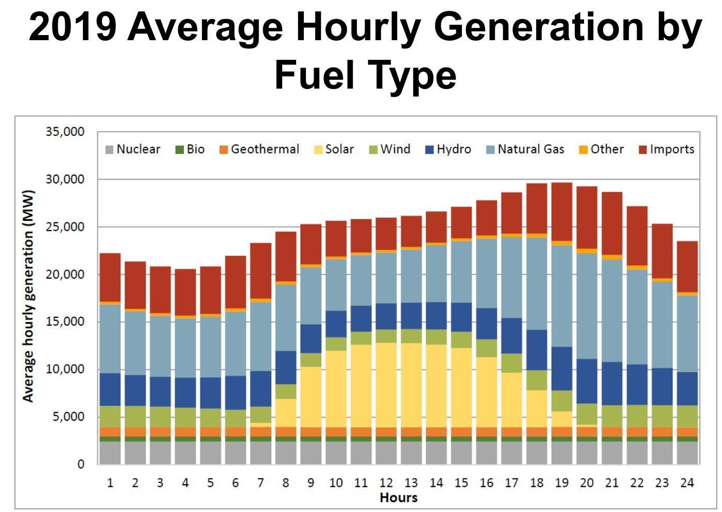

In [ ]:
# ==========================     USER INPUTS     ==========================

image_filepath: Optional[str] = None  # "energy_electricity_generation.jpg"
query = "Which hour of the day had the highest overall electricity generation in 2019?"

# =========================================================================

if image_filepath:
    assert Path(image_filepath).is_file(), f"Cannot find the image file at `{image_filepath}`"
    image = Image.open(image_filepath)
else:
    image = load_image_from_url(
        "https://github.com/tonywu71/colpali-cookbooks/blob/main/examples/data/energy_electricity_generation.jpg?raw=true"
    )

# Preview the image
scale_image(image, 512)

## Preprocess and embed the query and the image

In [5]:
# Preprocess inputs
batch_images = processor.process_images([image]).to(device)
batch_queries = processor.process_queries([query]).to(device)

# Forward passes
with torch.no_grad():
    image_embeddings = model.forward(**batch_images)
    query_embeddings = model.forward(**batch_queries)

## Get the per-token similarity maps

First step is to compute all the similarity scores between the query tokens and the image patches. Then, we reshape the resulting tensor to make the image structure appear clearly in the tensor shape.

In [6]:
# Get the number of image patches
n_patches = processor.get_n_patches(
    image_size=image.size,
    patch_size=model.patch_size,
    spatial_merge_size=model.spatial_merge_size,
)

print(f"Number of image patches: {n_patches}")

# Get the tensor mask to filter out the embeddings that are not related to the image
image_mask = processor.get_image_mask(batch_images)

Number of image patches: (32, 23)


In [7]:
# Generate the similarity maps
batched_similarity_maps = get_similarity_maps_from_embeddings(
    image_embeddings=image_embeddings,
    query_embeddings=query_embeddings,
    n_patches=n_patches,
    image_mask=image_mask,
)

# Get the similarity map for our (only) input image
similarity_maps = batched_similarity_maps[0]  # (query_length, n_patches_x, n_patches_y)

print(f"Similarity map shape: (query_length, n_patches_x, n_patches_y) = {tuple(similarity_maps.shape)}")

Similarity map shape: (query_length, n_patches_x, n_patches_y) = (40, 32, 23)


The following cell will display the tokens of the query. For clarity, we will ask the user to select the token for which they want to visualize the similarity map.

In [8]:
# Use this cell output to choose a token using its index
query_content = processor.decode(batch_queries.input_ids[0]).replace(processor.tokenizer.pad_token, "")
query_content = query_content.replace(processor.query_augmentation_token, "").strip()
query_tokens = processor.tokenizer.tokenize(query_content)

pprint.pprint({idx: val for idx, val in enumerate(query_tokens)})

{0: 'Query',
 1: ':',
 2: 'ĠWhich',
 3: 'Ġhour',
 4: 'Ġof',
 5: 'Ġthe',
 6: 'Ġday',
 7: 'Ġhad',
 8: 'Ġthe',
 9: 'Ġhighest',
 10: 'Ġoverall',
 11: 'Ġelectricity',
 12: 'Ġgeneration',
 13: 'Ġin',
 14: 'Ġ',
 15: '2',
 16: '0',
 17: '1',
 18: '9',
 19: '?'}


## Select the query token of interest

In [9]:
# Choose a token using its index
token_idx = 3  # e.g. if "3: 'Ġhour',", set 3 to choose the token 'Ġhour'

print(f"Selected token: `{query_tokens[token_idx]}`")

# Retrieve the similarity map for the chosen token
current_similarity_map = similarity_maps[token_idx]  # (n_patches_x, n_patches_y)

Selected token: `Ġhour`


## Visualize the similarity map for the current query token

The brighter the patch, the higher similarity score it has with the selected token.

For instance, the default similarity map exhibits OCR capabilities and chart understanding of ColQwen2. For the “Ġhour” token, the model highlights both the “hour” label and all the values along the time x-axis. 

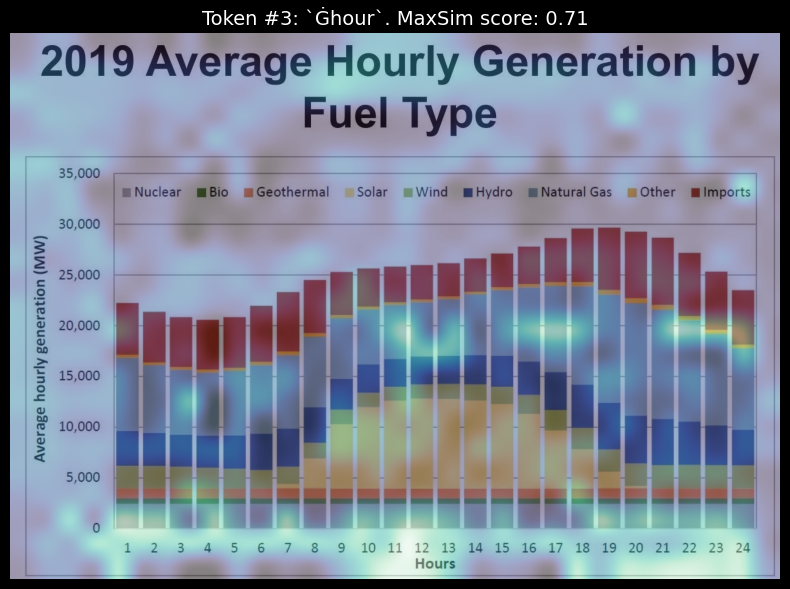

In [11]:
fig, ax = plot_similarity_map(
    image=image,
    similarity_map=current_similarity_map,
    figsize=(8, 8),
    show_colorbar=False,
)

max_sim_score = similarity_maps[token_idx, :, :].max().item()
ax.set_title(f"Token #{token_idx}: `{query_tokens[token_idx]}`. MaxSim score: {max_sim_score:.2f}", fontsize=14)

fig

**Additional note:** You should notice a few white patches with high similarity scores. This behavior might first seem surprising as the white patches should not carry a meaningful signal from the original images. We believe the vectors associated with these patches share a similar role with the ViT registers [(Darcet et al., 2023)](https://doi.org/10.48550/arXiv.2309.16588), i.e. these patches were repurposed for internal computations and stored the global information from the whole image.

## Bonus: Generate similarity maps for all query tokens

You can use the higher-level function `generate_similarity_maps` to generate similarity maps for all query tokens.

In [12]:
plots = plot_all_similarity_maps(
    image=image,
    query_tokens=query_tokens,
    similarity_maps=similarity_maps,
    figsize=(8, 8),
    show_colorbar=False,
    add_title=True,
)

for idx, (fig, ax) in enumerate(plots):
    savepath = f"similarity_map_{idx}.png"
    fig.savefig(savepath, bbox_inches="tight")
    print(f"Similarity map for token `{query_tokens[idx]}` saved at `{savepath}`")

plt.close("all")

/Users/tony/Desktop/colpali-cookbooks/.venv/lib/python3.10/site-packages/colpali_engine/interpretability/similarity_maps.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


Similarity map for token `Query` saved at `similarity_map_0.png`
Similarity map for token `:` saved at `similarity_map_1.png`
Similarity map for token `ĠWhich` saved at `similarity_map_2.png`
Similarity map for token `Ġhour` saved at `similarity_map_3.png`
Similarity map for token `Ġof` saved at `similarity_map_4.png`
Similarity map for token `Ġthe` saved at `similarity_map_5.png`
Similarity map for token `Ġday` saved at `similarity_map_6.png`
Similarity map for token `Ġhad` saved at `similarity_map_7.png`
Similarity map for token `Ġthe` saved at `similarity_map_8.png`
Similarity map for token `Ġhighest` saved at `similarity_map_9.png`
Similarity map for token `Ġoverall` saved at `similarity_map_10.png`
Similarity map for token `Ġelectricity` saved at `similarity_map_11.png`
Similarity map for token `Ġgeneration` saved at `similarity_map_12.png`
Similarity map for token `Ġin` saved at `similarity_map_13.png`
Similarity map for token `Ġ` saved at `similarity_map_14.png`
Similarity map f